In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")
import copy
import os
import logging
from src.utils import logging_utils
from src import functional
from src.models import ModelandTokenizer
# from src.data import load_relation
import json

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [3]:
RESULTS_DIR = os.path.join("../../", "results")
FIGURS_DIR = os.path.join("../../", "Figures")

causal_tracing_dir = os.path.join(RESULTS_DIR, "causal_tracing_aie")

hooks = os.listdir(causal_tracing_dir)
hooks

['residual', 'ssm_after_ssm', 'after_down_proj', 'mlp_after_silu']

country_capital_city.json - 17 samples
2024-03-25 11:53:42 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f384ebbefe0>
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


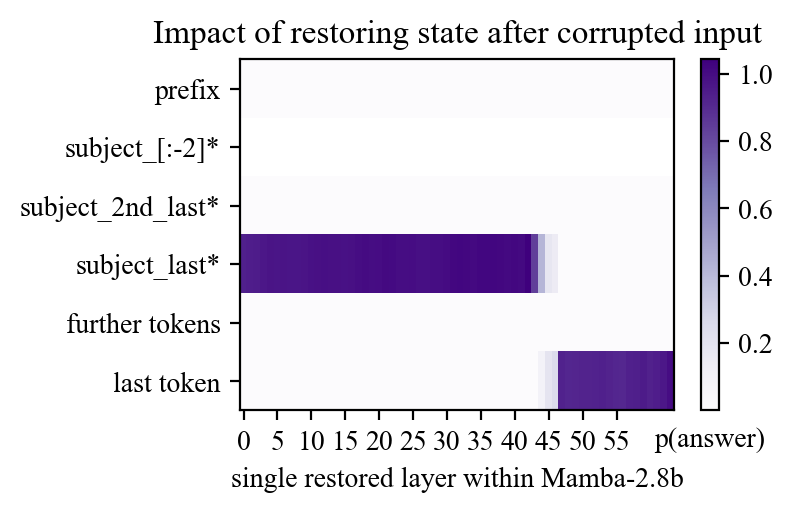

person_plays_pro_sport.json - 150 samples
2024-03-25 11:53:42 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f384f7bf0a0>
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


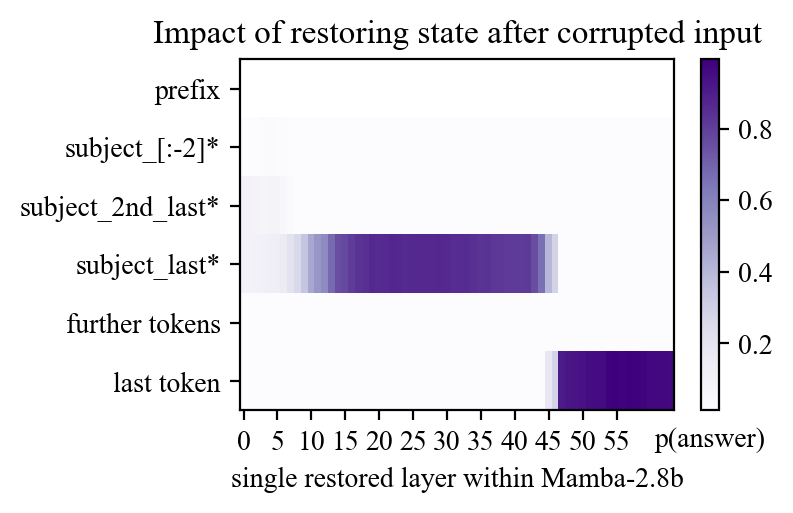

company_hq.json - 150 samples
2024-03-25 11:53:42 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f384eb20400>
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


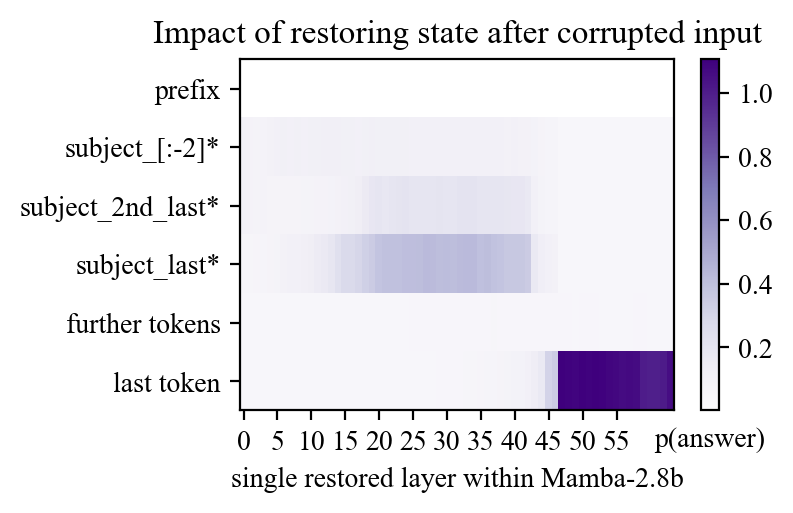

landmark_in_country.json - 150 samples
2024-03-25 11:53:42 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f384e641f60>
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


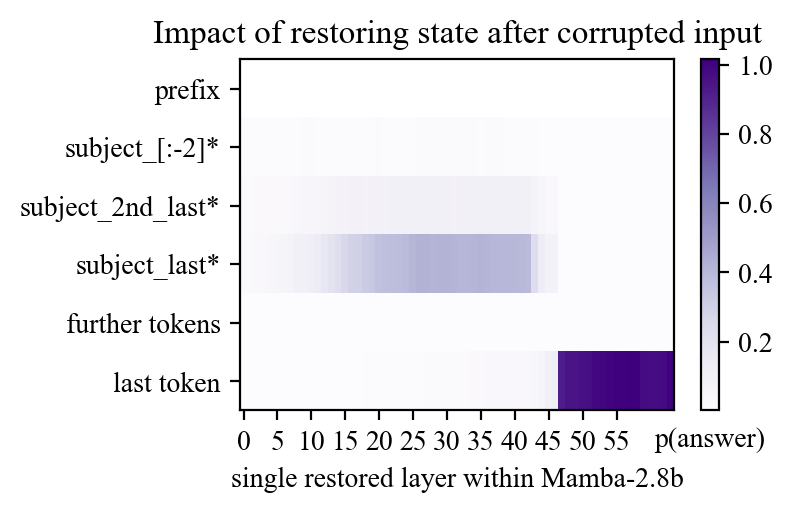

company_ceo.json - 34 samples
2024-03-25 11:53:42 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f3863df0c40>
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


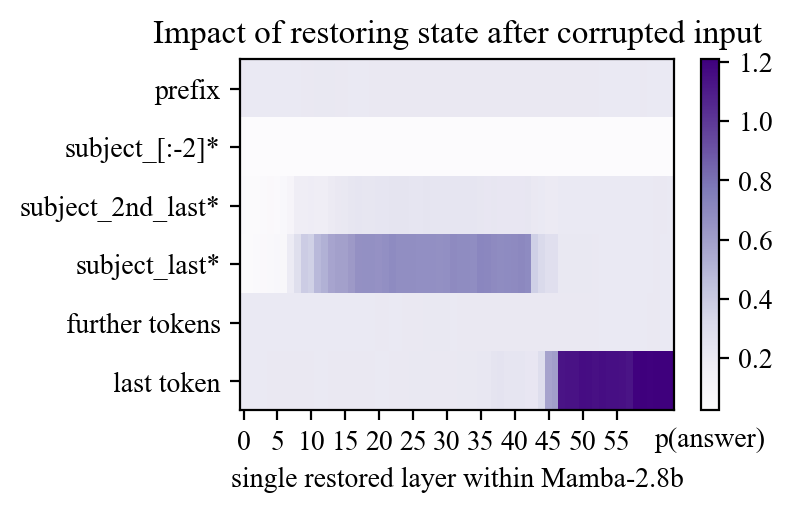

person_occupation.json - 51 samples
2024-03-25 11:53:43 matplotlib.colorbar DEBUG    colorbar update normal <matplotlib.colors.Normalize object at 0x7f384e5a9f00> <matplotlib.colors.Normalize object at 0x7f384e5a9f00>
2024-03-25 11:53:43 matplotlib.colorbar DEBUG    colorbar update normal <matplotlib.colors.Normalize object at 0x7f384e5a9f00> <matplotlib.colors.Normalize object at 0x7f384e5a9f00>
2024-03-25 11:53:43 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f384e942e00>
2024-03-25 11:53:43 matplotlib.colorbar DEBUG    colorbar update normal <matplotlib.colors.Normalize object at 0x7f384e5a9f00> <matplotlib.colors.Normalize object at 0x7f384e5a9f00>
2024-03-25 11:53:43 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f384e942e00>
2024-03-25 11:53:43 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f384e942e00>
2024-03-25 11:53:43 matplotlib.colorbar DEBUG    colorbar update normal <

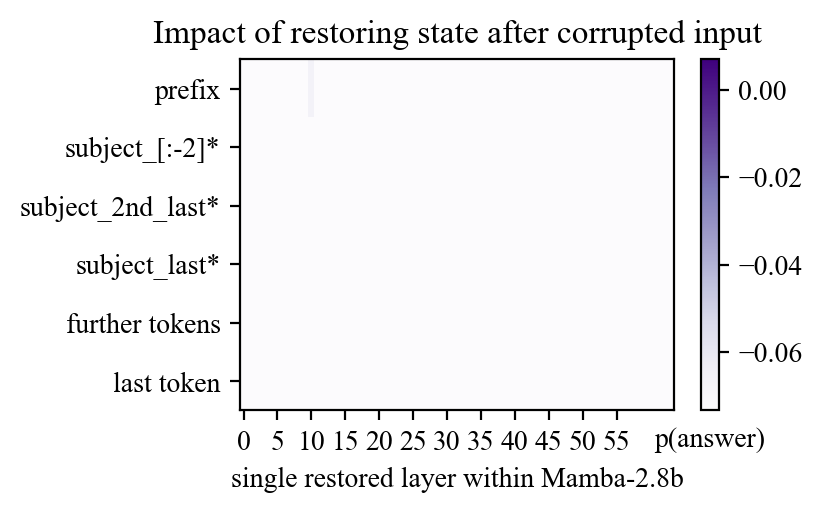

product_by_company.json - 150 samples
2024-03-25 11:53:43 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f384fb2a200>
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


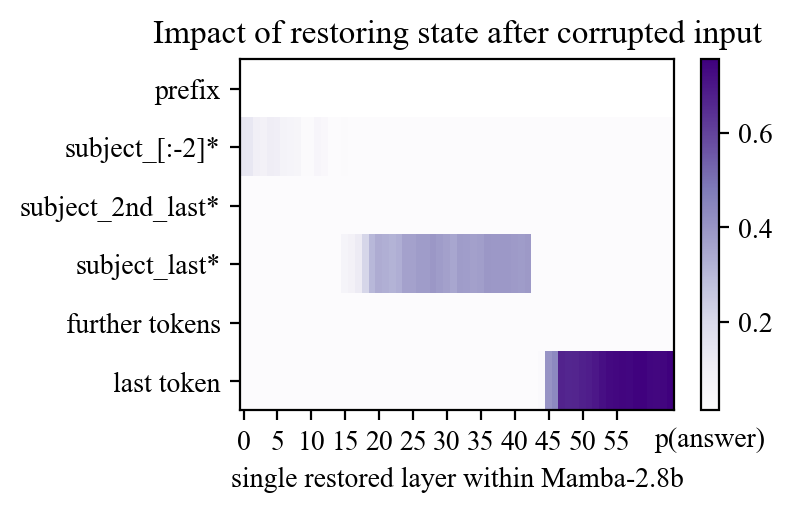

place_in_city.json - 100 samples
2024-03-25 11:53:43 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f384e6785e0>
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


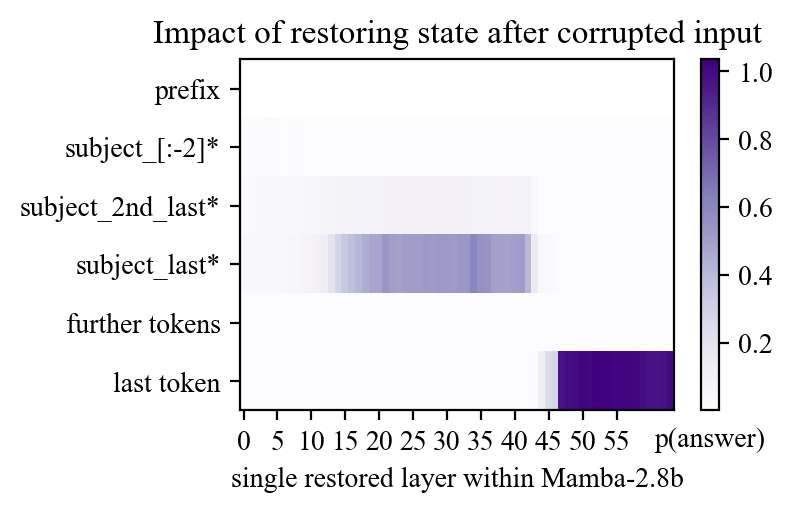

In [32]:
from src.tracing import average_indirect_effects
from src.plotting import plot_trace_heatmap
from typing import Literal

# hook = hooks[0]
hook: Literal["residual", "ssm_after_ssm", "mlp_after_silu", "after_down_proj"] = "residual"

save_dir = os.path.join(FIGURS_DIR, "causal_tracing_aie", hook)

relation_files = os.listdir(os.path.join(causal_tracing_dir, hook))

aie_all = {}

for relation_file in relation_files:

    with open(os.path.join(causal_tracing_dir, hook, relation_file), "r") as f:
        relation_ie_all = json.load(f)

    if relation_file == "person_native_language.json":
        continue
    
    print(f"{relation_file} - {len(relation_ie_all.keys())} samples")

    for k, v in relation_ie_all.items():
        aie_all[f"{k}_{relation_file}_{hook}"] = v

    relation_aie = average_indirect_effects(relation_ie_all, relative_recovery = True)
    plot_trace_heatmap(
        relation_aie, 
        # savepdf=os.path.join(save_dir, f"{relation_file}.pdf"),
        modelname="Mamba-2.8b"
    )

802
2024-03-25 11:53:43 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f384e6170d0>
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-03-25 11:53:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


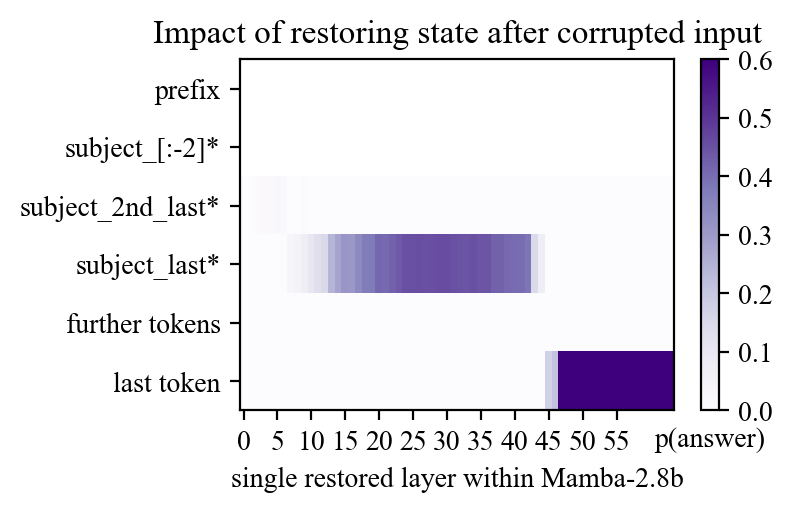

In [33]:
print(len(aie_all.keys()))

aie = average_indirect_effects(aie_all, relative_recovery = True)
plot_trace_heatmap(
    aie, 
    # savepdf=os.path.join(save_dir, f"0_residual_tracing.pdf"),
    modelname="Mamba-2.8b", 
    scale_range=(0.0, 0.6)
)